### Activate the auto-reload

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the libraries

In [19]:
import sys
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

### Set file path to parent directory

In [20]:
sys.path.append(str(Path().resolve().parent / "src"))
os.chdir("../")

### Import the homemade functions

In [21]:
from src.data.data_import import DataImporter
from src.features.generate_features import GenerateFeatures

### Get the API keys to access UN data

How-to available at this address: [https://uncomtrade.org/docs/api-subscription-keys/](https://uncomtrade.org/docs/api-subscription-keys/)

In [22]:
UN_API_KEY = "<YOUR_API_KEY>"

# 1. Import the data

In [23]:
importer = DataImporter(api_key=UN_API_KEY)
df = importer.get_merged_data()
df.head(2)

Reading merged data from: /Users/tuelanle/Documents/GitHub/graspp-25S-trade/data/interim/merge.csv


,,Export,Import,ILO
country,year,,,
ABW,2010,124523218.0,1.071034e+09,6.738
AFG,2014,570534007.0,7.697178e+09,1389.950


# 2. Descriptive Statistics

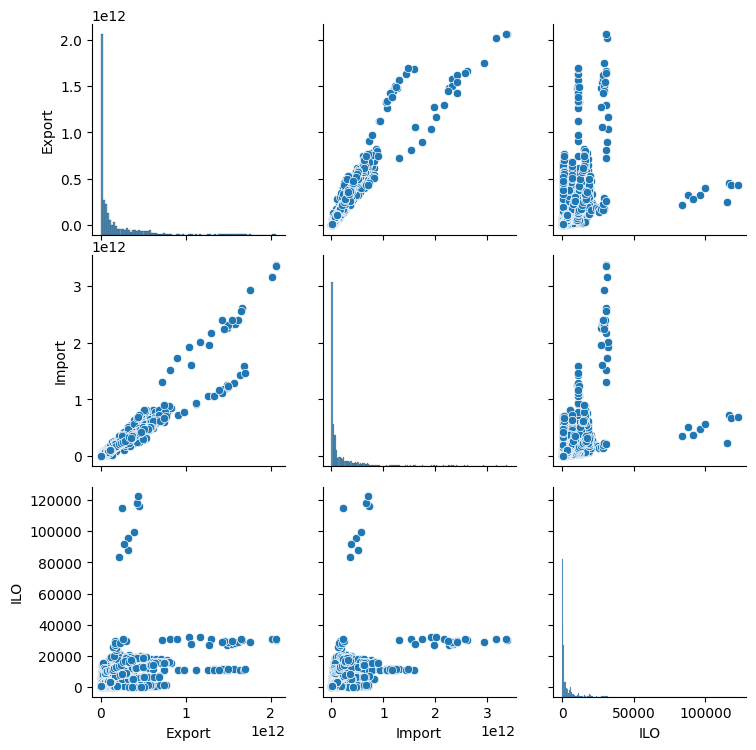

In [24]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

# 3. Conducting Regression Analysis - Wanonno Iqtyider

                            OLS Regression Results                            
Dep. Variable:            Q("Export")   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     445.2
Date:                Mon, 26 May 2025   Prob (F-statistic):           5.59e-89
Time:                        11:24:04   Log-Likelihood:                -52620.
No. Observations:                1908   AIC:                         1.052e+05
Df Residuals:                    1906   BIC:                         1.053e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.367e+10   5.67e+09     16.516      0.0

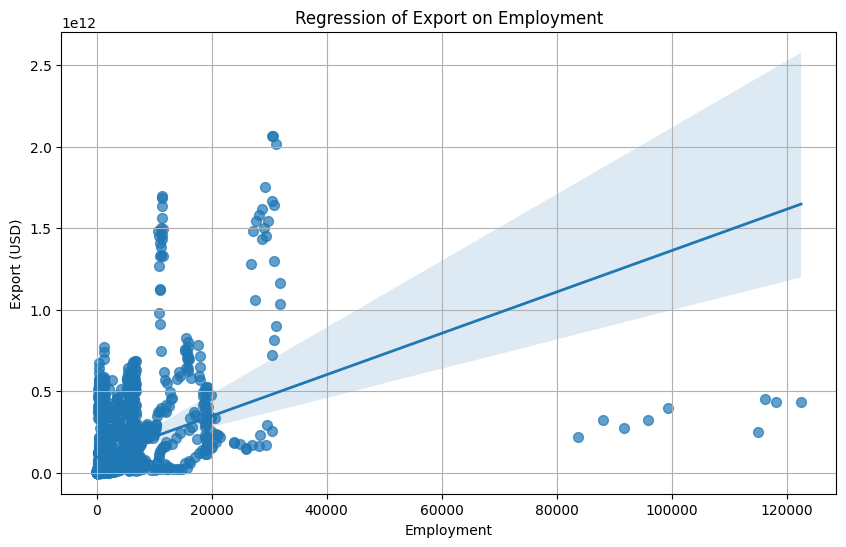

In [25]:
# 2. Prepare the data
# Make sure 'employment' and 'total trade value' exist without NaNs
df_regression = df.dropna(subset=["Export", "ILO"]).reset_index()

# 3. Run the regression using formula
# Note: you need to handle spaces in column names by using `Q("column name")` inside the formula
model = smf.ols(formula='Q("Export") ~ ILO', data=df_regression).fit()

# 4. Print regression summary
print(model.summary())

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_regression,
    x="ILO",
    y="Export",
    scatter_kws={"s":50, "alpha":0.7},
    line_kws={"linewidth":2}
)
plt.title('Regression of Export on Employment')
plt.xlabel('Employment')
plt.ylabel('Export (USD)')
plt.grid(True)
plt.show()


# 4. Analysis on the correlation between changes in employment and trade volume - Yijing

## 4.1 Plotting the change in employment throughout countries using ILO dataset

In [26]:
print(df.columns)
df.head(2)

Index(['Export', 'Import', 'ILO'], dtype='object')


,,Export,Import,ILO
country,year,,,
ABW,2010,124523218.0,1.071034e+09,6.738
AFG,2014,570534007.0,7.697178e+09,1389.950


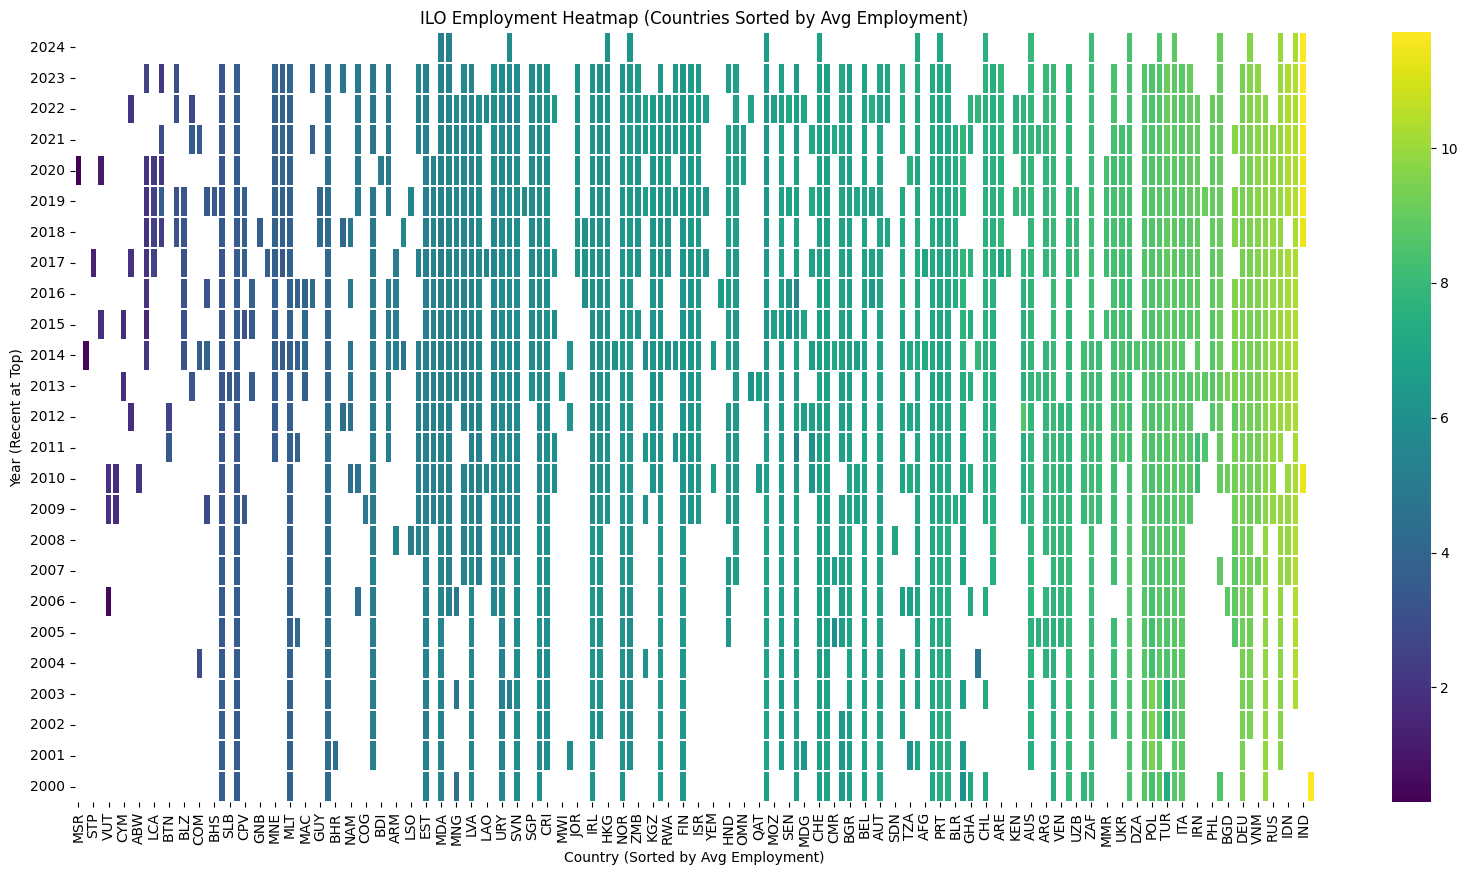

In [27]:
# In the heatmap, countries positioned further to the right and shaded in lighter colors generally exhibit higher average employment
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_heatmap = df['ILO'].unstack(level=0)
df_heatmap = df_heatmap.sort_index(ascending=False)

# Sort countries (columns) by average employment (low → high)
avg_employment = df_heatmap.mean(axis=0)
df_heatmap = df_heatmap[avg_employment.sort_values().index]

# Plot
plt.figure(figsize=(20, 10))
sns.heatmap(np.log1p(df_heatmap), cmap='viridis', linewidths=0.1)
plt.title("ILO Employment Heatmap (Countries Sorted by Avg Employment)")
plt.xlabel("Country (Sorted by Avg Employment)")
plt.ylabel("Year (Recent at Top)")
plt.show()

## 4.2 Regression analysis of the correlation between changes in employment and trade volume

In [28]:
# Differ from Wanno's regression, it analyzes the relationship between year-to-year changes in employment
# and total trade volume (Export + Import, as Trade_diff), rather than using absolute values.
# Unlike the previous analysis that examined whether high employment correlates with high exports,
# this approach focuses on whether increases in trade are associated with increases in employment over time.
df['Total_Trade'] = df['Export'] + df['Import']
df_merge = df.sort_index()


In [29]:
# Percentage changes


features_generator = GenerateFeatures(time_period="Y")
df_features = features_generator.transform(df_merge)
df_clean = df_features.dropna(subset=['ILO_chpct1Y', 'Total_Trade_chpct1Y'])

/Users/tuelanle/Documents/GitHub/graspp-25S-trade/src/features/generate_features.py:73: FutureWarning: The default fill_method='ffill' in DataFrameGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct_change = group_obj[num_cols].pct_change().add_suffix(f'_chpct1{self.time_period}')


In [30]:
correlation = df_clean['ILO_chpct1Y'].corr(df_clean['Total_Trade_chpct1Y'])
print("Correlation between percentage change in employment and trade volume:", correlation)


Correlation between percentage change in employment and trade volume: 0.18951664122133619


Text(0.5, 1.0, 'Regression Analysis of Employment and Trade Volume Changes')

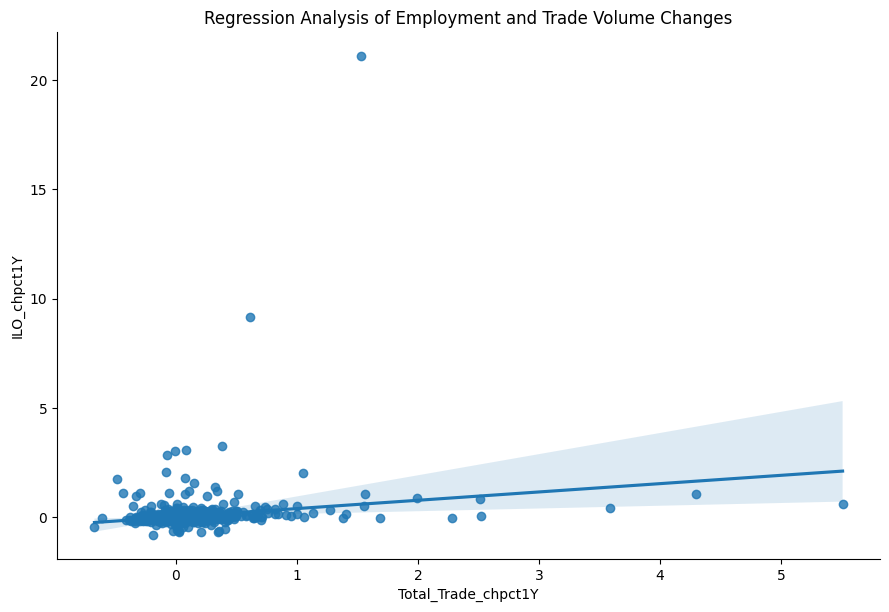

In [31]:
import seaborn as sns
sns.lmplot(x='Total_Trade_chpct1Y', y='ILO_chpct1Y', data=df_clean, height=6, aspect=1.5)
plt.title("Regression Analysis of Employment and Trade Volume Changes")
# Interpretation: When a country's total trade volume increases, its employment tends to increase, on average.

## 4.3 Histogram for percentage change in employment and trade

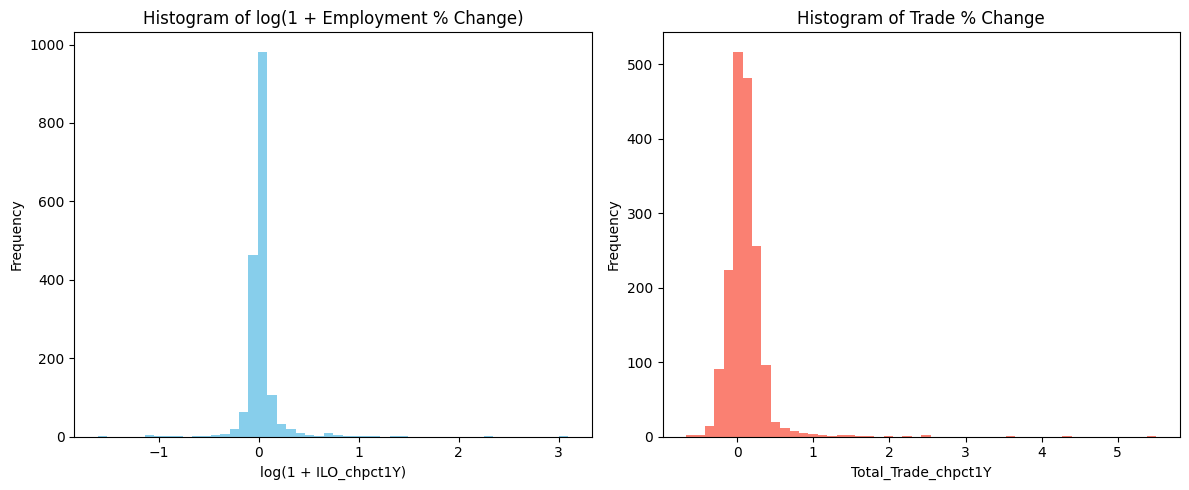

In [32]:
# Plot histogram for percentage change in employment
# I use log for pct change in employment to reduce the effect of extreme values as the distribution without log was heavily right-skewed

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log1p(df_clean['ILO_chpct1Y']), bins=50, color='skyblue')
plt.title("Histogram of log(1 + Employment % Change)")
plt.xlabel("log(1 + ILO_chpct1Y)")
plt.ylabel("Frequency")

# Plot histogram for percentage change in trade
plt.subplot(1, 2, 2)
plt.hist(df_clean['Total_Trade_chpct1Y'], bins=50, color='salmon')
plt.title("Histogram of Trade % Change")
plt.xlabel("Total_Trade_chpct1Y")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 4.4 Identifying Outliers in Industry Employment Change (Lan)

To explore whether more trade leads to less industry employment, we examine outliers in year-on-year changes in industry employment (`ILO_chpct1Y`). 

The distribution of these changes is heavily right-skewed, so a logarithmic transformation was applied in the histogram to reduce the influence of extreme positive values. However, to investigate specific cases, we focus on the original (unlogged) percentage changes.

We define outliers as observations where:
- `ILO_chpct1Y < 0`: indicating a significant **drop** in industry employment, or
- `ILO_chpct1Y > 1`: indicating a **very large increase** (greater than 100%) in one year.

These data points are interesting candidates for further investigation:
- Sudden employment drops might reflect economic shocks, trade liberalization effects, or reclassification issues.
- Large increases could signal industrial booms, post-crisis recovery, or methodological changes in data collection.

By identifying these outliers, we aim to isolate potential case studies that help us understand the mechanisms through which trade may influence industrial employment — or reveal anomalies that require cautious interpretation.

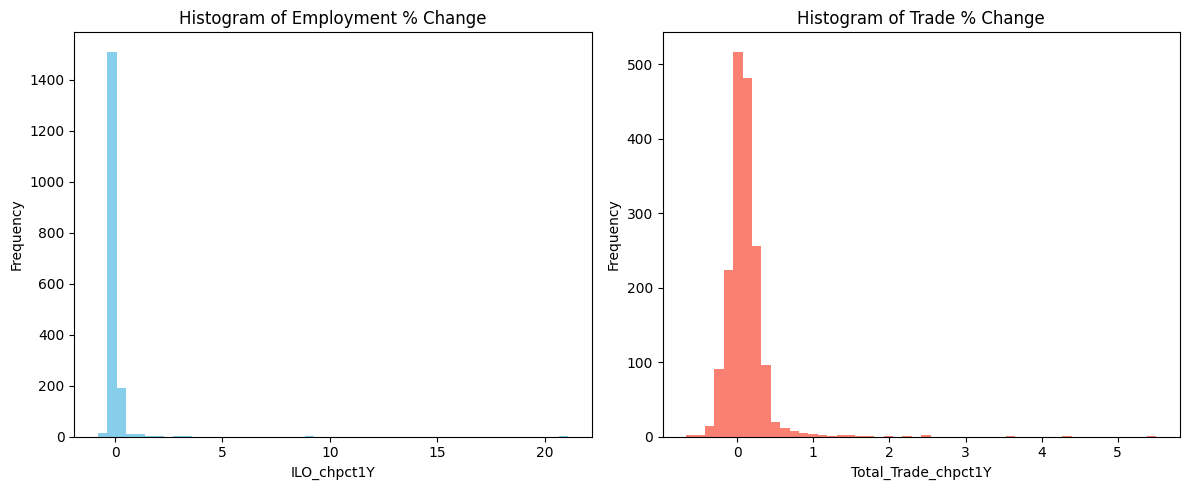

In [39]:
# Plot histogram for percentage change in employment

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean['ILO_chpct1Y'], bins=50, color='skyblue')
plt.title("Histogram of Employment % Change")
plt.xlabel("ILO_chpct1Y")
plt.ylabel("Frequency")

# Plot histogram for percentage change in trade
plt.subplot(1, 2, 2)
plt.hist(df_clean['Total_Trade_chpct1Y'], bins=50, color='salmon')
plt.title("Histogram of Trade % Change")
plt.xlabel("Total_Trade_chpct1Y")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [45]:
# Find outliers: large negative or large positive changes
outliers = df_clean[(df_clean["ILO_chpct1Y"] > 1)]

# View them
outliers.ILO_chpct1Y


country  year
AGO      2019     1.085102
ARE      2018     1.177343
BEN      2022     1.197903
CMR      2007     1.400206
GMB      2023     1.058877
GRD      2019     2.863972
         2021     1.586612
IRN      2013     1.110232
LKA      2012     2.082554
MAR      2014    21.108482
MDV      2014     2.028510
PAN      2023     1.087720
POL      2001     1.798149
SEN      2019     1.079274
SLE      2018     1.761534
SVK      2012     3.006067
         2017     3.094925
TUR      2004     3.265024
TZA      2006     1.066061
UGA      2012     1.075431
VUT      2009     9.174579
Name: ILO_chpct1Y, dtype: float64

In [34]:
outliers_sorted = outliers.sort_values("ILO_chpct1Y")

In [35]:
outliers_sorted.reset_index()[["country", "year", "ILO_chpct1Y", "Total_Trade_chpct1Y"]]
outliers_sorted.head(10)

,,Export,Import,ILO,Total_Trade,Export_chraw1Y,Import_chraw1Y,ILO_chraw1Y,Total_Trade_chraw1Y,Export_chpct1Y,Import_chpct1Y,...,ILO_lag1Y,Total_Trade_lag1Y,Export_lag2Y,Import_lag2Y,ILO_lag2Y,Total_Trade_lag2Y,Export_zscoreY,Import_zscoreY,ILO_zscoreY,Total_Trade_zscoreY
country,year,,,,,,,,,,,,,,,,,,,,,
GRD,2020,2.462048e+07,3.945516e+08,7.753,4.191721e+08,-9.860704e+06,-8.528296e+07,-30.964,-9.514367e+07,-0.285973,-0.177734,...,38.717,5.143158e+08,3.774609e+07,5.148057e+08,10.020,5.525518e+08,-1.600378,-1.313692,-0.752626,-1.342794
POL,2004,7.377888e+10,8.815110e+10,3976.099,1.619300e+11,2.102338e+10,2.100498e+10,-7872.145,4.202836e+10,0.398506,0.312825,...,11848.244,1.199016e+11,4.025390e+10,5.426634e+10,12049.771,9.452024e+10,-1.079470,-1.076241,-0.722427,-1.079705
SVK,2011,7.899858e+10,7.879915e+10,218.245,1.577977e+11,1.370921e+10,1.315354e+10,-424.504,2.686276e+10,0.209976,0.200372,...,642.749,1.309350e+11,5.555302e+10,5.515994e+10,897.633,1.107130e+11,0.429133,0.427861,-2.880855,0.428865
LKA,2013,1.000488e+10,1.793081e+10,1927.193,2.793569e+10,6.350949e+08,4.588714e+07,-3681.733,6.809820e+08,0.067781,0.002566,...,5608.926,2.725471e+10,1.001128e+10,1.969648e+10,1819.571,2.970776e+10,-0.368724,0.060959,-0.414999,-0.092569
SVK,2016,7.699000e+10,7.494113e+10,229.686,1.519311e+11,1.979942e+09,1.836281e+09,-431.423,3.816223e+09,0.026396,0.025118,...,661.109,1.481149e+11,8.577410e+10,8.116528e+10,876.037,1.669394e+11,0.364318,0.300548,-2.822622,0.333070
GRD,2023,4.605509e+07,6.087590e+08,7.133,6.548141e+08,1.089170e+07,1.620827e+08,-12.921,1.729744e+08,0.309745,0.362864,...,20.054,4.818397e+08,2.462048e+07,3.945516e+08,7.753,4.191721e+08,1.520172,1.668094,-0.804576,1.660233
KIR,2020,9.271010e+06,1.089471e+08,1.830,1.182181e+08,-7.376990e+05,-1.781924e+06,-3.244,-2.519623e+06,-0.073706,-0.016093,...,5.074,1.207377e+08,NaN,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000
BTN,2012,5.312270e+08,9.917026e+08,12.046,1.522930e+09,7.826424e+07,-6.004473e+07,-17.754,1.821951e+07,0.172783,-0.057090,...,29.800,1.504710e+09,NaN,NaN,NaN,NaN,1.000000,-1.000000,-1.000000,1.000000
TLS,2022,4.717738e+08,9.334616e+08,14.574,1.405235e+09,1.347059e+07,3.911420e+08,-16.958,4.046126e+08,0.029392,0.721239,...,31.532,1.000623e+09,5.313602e+07,5.137385e+08,26.572,5.668745e+08,0.741497,1.411585,-1.355800,1.210313


## Plots for Case Study Candidates: Poland, Slovakia, Sri Lanka, Grenada

- Did trade increase while employment dropped?
- Were they moving together or diverging?
- Were there abrupt breaks or turning points?

In [36]:
def plot_country_trends(df, country_code, start_year=2000, end_year=2024):
    df_country = df.loc[country_code]
    df_country = df_country[(df_country.index >= start_year) & (df_country.index <= end_year)]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_title(f"{country_code} – Industry Employment and Trade (2000–2024)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Industry Employment", color="blue")
    ax1.plot(df_country.index, df_country["ILO"], marker="o", color="blue", label="Industry Employment")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Total Trade Value", color="green")
    ax2.plot(df_country.index, df_country["Total_Trade"], marker="s", color="green", linestyle="--", label="Total Trade")
    ax2.tick_params(axis="y", labelcolor="green")

    fig.tight_layout()
    plt.show()

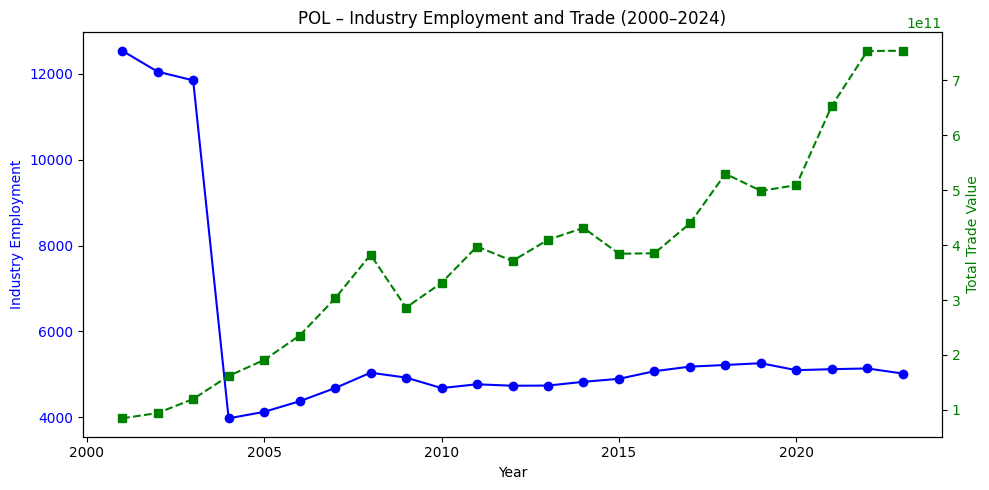

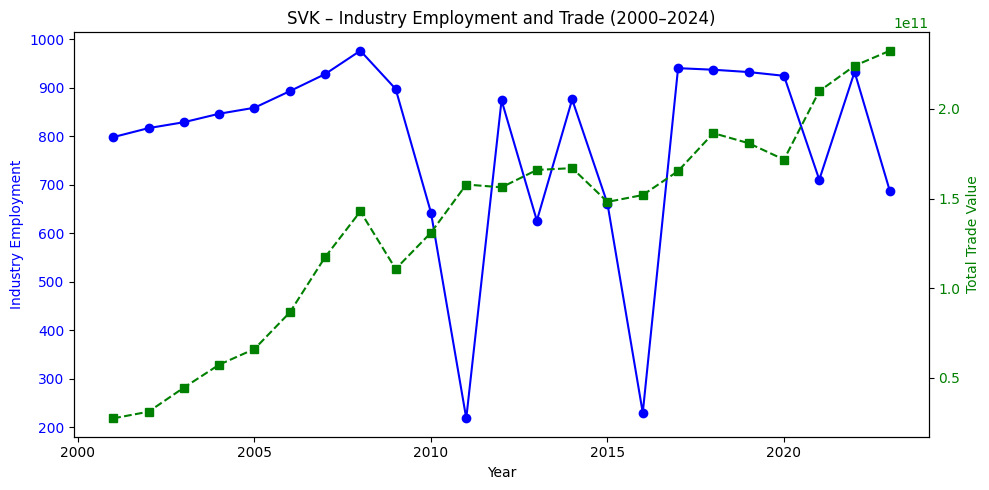

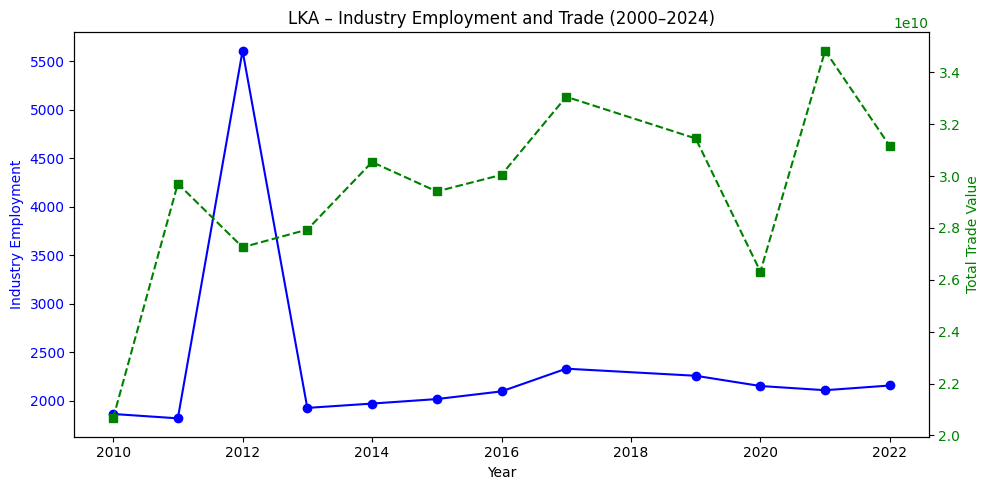

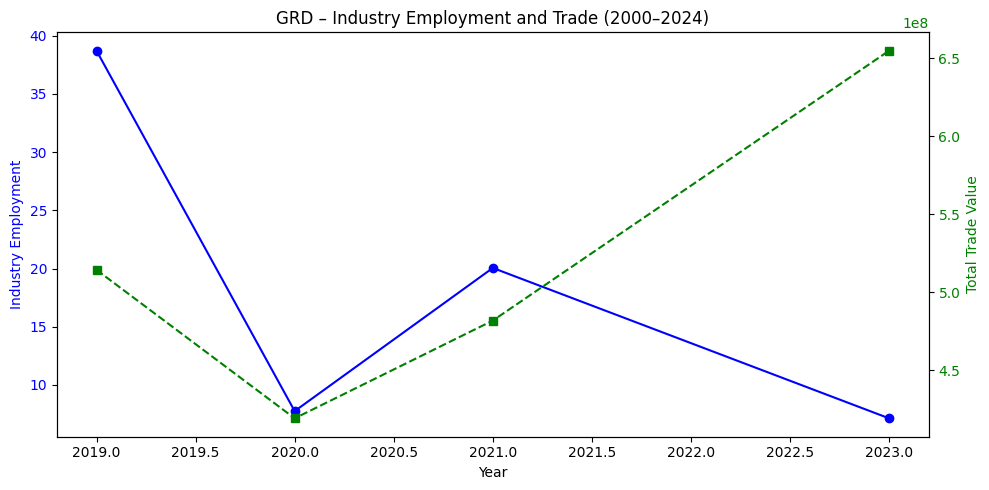

In [37]:
plot_country_trends(df_clean, "POL")  # Poland
plot_country_trends(df_clean, "SVK")  # Slovakia
plot_country_trends(df_clean, "LKA")  # Sri Lanka
plot_country_trends(df_clean, "GRD")  # Grenada